In [58]:
#importing dependencies related to nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##########
#importing dependencies related to image transformations
import torchvision
from torchvision import transforms
##########
from PIL import Image
###########
#importing dependencies related to data loading
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
#########################
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
#####################
#importing Tensorboard for data visualization
#from torch.utils.tensorboard import SummaryWriter

In [5]:
#defining image transformations
#train
image_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

#defining image transformations
#validation
image_transforms_valid = transforms.Compose([
    transforms.Resize(size=(64,64)),
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

#defining image transformations
#test
image_transforms_test = transforms.Compose([
    transforms.Resize(size=(64,64)),
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [6]:
#dataset directory(location)
path_data_train=r"Face Mask Dataset\Train"
path_data_valid=r"Face Mask Dataset\Validation"
path_data_test=r"Face Mask Dataset\Test"

In [7]:
# loading data from location
data_train= datasets.ImageFolder(root=path_data_train, transform=image_transforms)
data_valid=datasets.ImageFolder(root=path_data_valid, transform=image_transforms_valid)
data_test=datasets.ImageFolder(root=path_data_test, transform=image_transforms_test)

In [8]:
print(len(data_train),len(data_valid),len(data_test))

10000 800 992


In [ ]:
#split to train and test::::::::::::::::::::
#from torch.utils.data import random_split

#val_pct=0.2
#val_s=int(val_pct*len(data))
#train_s=int(len(data)-val_s)
#train,valid=random_split(data,[train_s,val_s])

In [9]:
#data to batch
dataloaders_train = DataLoader(data_train, batch_size=64, shuffle=True)
dataloaders_valid = DataLoader(data_valid, batch_size=300, shuffle=False)
dataloaders_test=DataLoader(data_test, batch_size=300, shuffle=False)
###########################

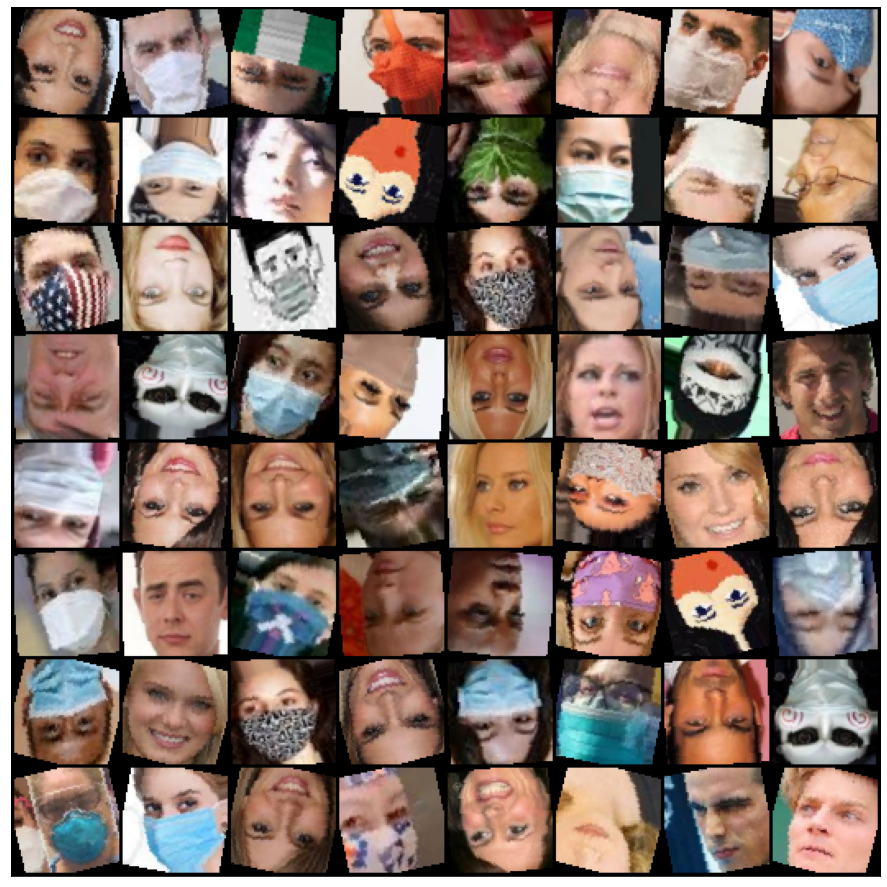

In [10]:
#show images::::::::with denormalize [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]

#denormalize data:::::
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
###################
stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
#stats = ([0, 0, 0],[1, 1,1])
###################

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(dataloaders_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


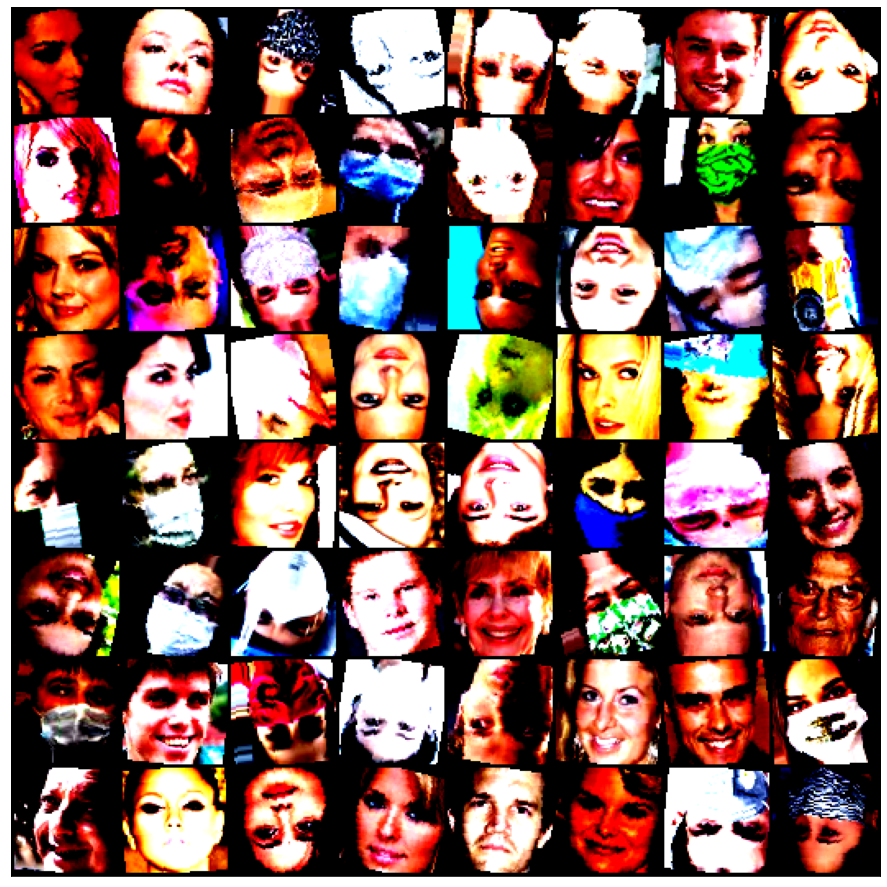

In [12]:
#show images::::::::with normalize [0.485, 0.456, 0.406],[0.229, 0.224, 0.225]

#denormalize data:::::
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)
###################
#stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
stats = ([0, 0, 0],[1, 1,1])
#stats = ([0,0,0],[255, 255, 255])
###################

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], *stats)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(dataloaders_train)

In [19]:
#loading MobileNetv2 (online)
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

In [27]:
#load model (mobilenet_v2) from device
from torchvision import models
model=models.mobilenet_v2(pretrained=True)

In [28]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [29]:
#freezing the initial layers of MobileNetv2(train only classifier layer)
for param in model.parameters():
    param.requires_grad = False
    #print(param)

In [31]:
# print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

0


In [32]:
#add classifier layer(last layer)
model.classifier=nn.Sequential(
                      nn.Linear(1280, 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 32),
                      nn.ReLU(),
                      nn.Dropout(0.4),
                      nn.Linear(32, 2), 
                      nn.Softmax(dim=1))
                      #nn.LogSoftmax(dim=1))

In [33]:
# print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

371234


In [34]:
#checking GPU Avaibility
if torch.cuda.is_available():
    print('training on GPU')
    device = torch.device("cuda:0")
else:
    print('training on CPU')
    device = torch.device("cpu")

training on CPU


In [50]:
#training data(train function)
from tqdm.notebook import tqdm #for loading bars

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs,device):
    #writer = SummaryWriter(path_data+"saves\\logs")
    acc=[]
    acc_v=[]
    loss_=[]
    loss_v=[]
    for epoch in tqdm(range(epochs)):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        num_correct = 0 
        num_examples = 0
        for batch in (train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
            ###############
            _, predicted = torch.max(output.data, 1)
            correct = torch.eq(predicted, targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
            ####################
        training_loss /= len(train_loader.dataset)
        accuracy_train=num_correct / num_examples
        model.eval()
        num_correct_v = 0 
        num_examples_v = 0
        for batch in (val_loader):
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            _, predicted = torch.max(output.data, 1)
            correct_v = torch.eq(predicted, targets).view(-1)
            num_correct_v += torch.sum(correct_v).item()
            num_examples_v += correct_v.shape[0]
        ###########################
        valid_loss /= len(val_loader.dataset)
        accuracy_valid=num_correct_v / num_examples_v
        ##########################
        acc.append(accuracy_train)
        acc_v.append(accuracy_valid)
        loss_.append(training_loss)
        loss_v.append(valid_loss)
        ###########################
        print('Epoch:{} ,Training Loss:{:.4f} ,Validation Loss:{:.4f} ,accuracy ={:.4f} ,accuracy_valid:{:.4f} '.format(epoch, training_loss,valid_loss,accuracy_train,accuracy_valid))

        #save model
        #if(training_loss<0.005):
        #    torch.save(model,path_data+"saves/"+str(epoch)+".pth")
        
        #tensorBoard save log
        #writer.add_scalar('Loss', loss.item(), epoch)
        #writer.add_scalar('Train/Loss', training_loss, epoch)
        #writer.add_scalar('Test/Loss', valid_loss, epoch)
        #writer.add_scalar('Test/Accuracy',num_correct / num_examples, epoch)
        #writer.flush()
    return acc,acc_v,loss_,loss_v

In [43]:
#testing data
def test_model(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloaders_test:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,'\n\n',outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('correct: {:d}  total: {:d}'.format(correct, total))
    print('accuracy = {:f}'.format(correct / total))

In [53]:
#plot_acc_loss:::::::::::::::::
def plot_acc_loss(history):
    # summarize history for accuracy
    plt.plot(h[0])
    plt.plot(h[1])
    ###################
    plt.ylim(0.4,1.0)
    plt.xlim(0,len(h[0]))
    ###################
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(h[2])
    plt.plot(h[3])
    ###################
    plt.ylim(0.3,0.6)
    plt.xlim(0,len(h[0]))
    ###################
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.savefig('loss_acc_model_1_.png')

In [56]:
#confusion_matrix:::::::::
def confusion_matrix_(dataloaders,model):
    y_pred = []
    y_true = []
    # iterate over test data
    with torch.no_grad():
        for inputs, labels in dataloaders:
                output = model(inputs) # Feed Network
                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction
                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth
    # constant for classes
    classes = data_test.classes
    ##########
    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    #df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
    #                     columns = [i for i in classes])
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    ###########################
    df_cm_p = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
    return df_cm,df_cm_p


In [46]:
#put model to GPU (if available)
model=model.to(device)

In [ ]:
#choosing optimizer and loss Function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()

In [40]:
#training::::::::::::::::
#1:train model on only last layer and freezing initial layers (acc:0.9225  ,loss:0.3886,lr=0.0001 ,Epoch:25)
#2:train model on last layer and (10-18 initial layers) (acc:0.9950  ,loss:0.0.3183,lr=0.0001,Epoch:25)
#3:train model on all layers(acc:0.1.0000,loss:0.0.3133 ,lr=0.00001,Epoch:10)

In [38]:
#train the model for 25 epochs
h=train(model, optimizer,loss,dataloaders_train,dataloaders_valid,25,device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:0 ,Training Loss:0.5929 ,Validation Loss:0.4351 ,accuracy =0.7481 ,accuracy_valid:0.8925 
Epoch:1 ,Training Loss:0.4268 ,Validation Loss:0.4006 ,accuracy =0.8923 ,accuracy_valid:0.9100 
Epoch:2 ,Training Loss:0.4149 ,Validation Loss:0.3914 ,accuracy =0.8974 ,accuracy_valid:0.9187 
Epoch:3 ,Training Loss:0.4030 ,Validation Loss:0.3991 ,accuracy =0.9093 ,accuracy_valid:0.9100 
Epoch:4 ,Training Loss:0.3996 ,Validation Loss:0.3884 ,accuracy =0.9138 ,accuracy_valid:0.9213 
Epoch:5 ,Training Loss:0.3984 ,Validation Loss:0.3943 ,accuracy =0.9132 ,accuracy_valid:0.9150 
Epoch:6 ,Training Loss:0.3970 ,Validation Loss:0.3891 ,accuracy =0.9134 ,accuracy_valid:0.9237 
Epoch:7 ,Training Loss:0.3990 ,Validation Loss:0.3887 ,accuracy =0.9122 ,accuracy_valid:0.9225 
Epoch:8 ,Training Loss:0.3967 ,Validation Loss:0.4029 ,accuracy =0.9150 ,accuracy_valid:0.9087 
Epoch:9 ,Training Loss:0.3983 ,Validation Loss:0.3832 ,accuracy =0.9118 ,accuracy_valid:0.9287 
Epoch:10 ,Training Loss:0.4024 ,Validati

In [44]:
#test the model
test_model(model)

correct: 906  total: 992
accuracy = 0.913306


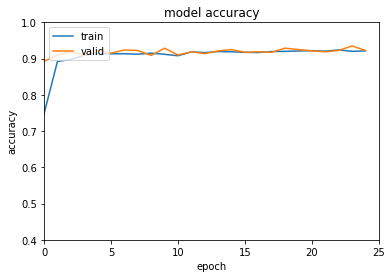

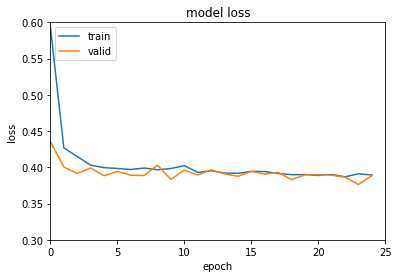

<Figure size 432x288 with 0 Axes>

In [52]:
#plot loss_acc
plot_acc_loss(h)

             WithMask  WithoutMask
WithMask          432           51
WithoutMask        35          474


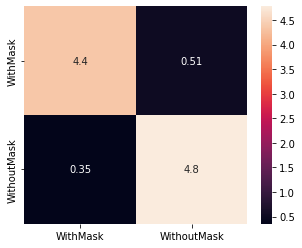

In [59]:
#plot confusion_matrix
df_cm,df_cm_p=confusion_matrix_(dataloaders_test,model)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm_p, annot=True)
plt.savefig('output_CM_model_1.png')
print(df_cm)

In [64]:
#unfreezing initial layers[10 to 18]
for i in range(10,19):
    for param in model.features[i].parameters():
        param.requires_grad = True
        #print(param)

In [65]:
# print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2410018


In [67]:
#train the model for 25 epochs
h=train(model, optimizer,loss,dataloaders_train,dataloaders_valid,25,device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:0 ,Training Loss:0.3617 ,Validation Loss:0.3363 ,accuracy =0.9499 ,accuracy_valid:0.9775 
Epoch:1 ,Training Loss:0.3366 ,Validation Loss:0.3284 ,accuracy =0.9763 ,accuracy_valid:0.9850 
Epoch:2 ,Training Loss:0.3379 ,Validation Loss:0.3406 ,accuracy =0.9747 ,accuracy_valid:0.9725 
Epoch:3 ,Training Loss:0.3311 ,Validation Loss:0.3296 ,accuracy =0.9819 ,accuracy_valid:0.9838 
Epoch:4 ,Training Loss:0.3338 ,Validation Loss:0.3252 ,accuracy =0.9794 ,accuracy_valid:0.9875 
Epoch:5 ,Training Loss:0.3358 ,Validation Loss:0.3259 ,accuracy =0.9768 ,accuracy_valid:0.9875 
Epoch:6 ,Training Loss:0.3249 ,Validation Loss:0.3220 ,accuracy =0.9882 ,accuracy_valid:0.9912 
Epoch:7 ,Training Loss:0.3291 ,Validation Loss:0.3183 ,accuracy =0.9835 ,accuracy_valid:0.9950 
Epoch:8 ,Training Loss:0.3236 ,Validation Loss:0.3196 ,accuracy =0.9896 ,accuracy_valid:0.9938 
Epoch:9 ,Training Loss:0.3236 ,Validation Loss:0.3158 ,accuracy =0.9893 ,accuracy_valid:0.9975 
Epoch:10 ,Training Loss:0.3224 ,Validati

In [68]:
#test the model
test_model(model)

correct: 983  total: 992
accuracy = 0.990927


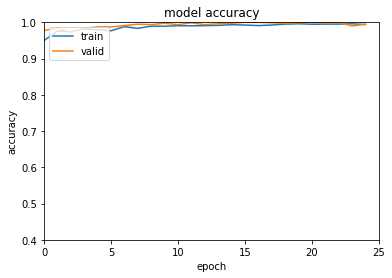

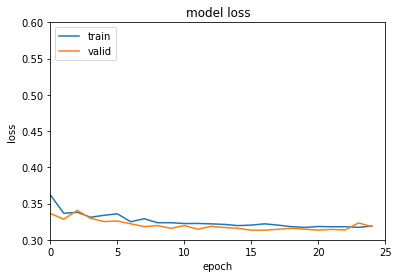

<Figure size 432x288 with 0 Axes>

In [69]:
#plot loss_acc
plot_acc_loss(h)

             WithMask  WithoutMask
WithMask          481            2
WithoutMask         7          502


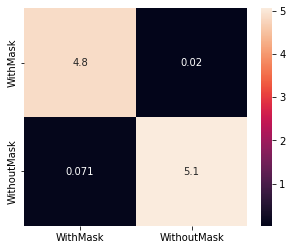

In [70]:
#plot confusion_matrix
df_cm,df_cm_p=confusion_matrix_(dataloaders_test,model)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm_p, annot=True)
plt.savefig('output_CM_model_2.png')
print(df_cm)

In [74]:
#freezing the initial layers of MobileNetv2(train only classifier layer)
for param in model.parameters():
    param.requires_grad = True
    #print(param)

In [75]:
# print number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2595106


In [76]:
#choosing optimizer and loss Function
optimizer = optim.Adam(model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()

In [77]:
#train the model for 10 epochs
h=train(model, optimizer,loss,dataloaders_train,dataloaders_valid,10,device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:0 ,Training Loss:0.3174 ,Validation Loss:0.3160 ,accuracy =0.9959 ,accuracy_valid:0.9962 
Epoch:1 ,Training Loss:0.3169 ,Validation Loss:0.3133 ,accuracy =0.9963 ,accuracy_valid:1.0000 
Epoch:2 ,Training Loss:0.3154 ,Validation Loss:0.3135 ,accuracy =0.9979 ,accuracy_valid:1.0000 
Epoch:3 ,Training Loss:0.3156 ,Validation Loss:0.3133 ,accuracy =0.9976 ,accuracy_valid:1.0000 
Epoch:4 ,Training Loss:0.3161 ,Validation Loss:0.3133 ,accuracy =0.9970 ,accuracy_valid:1.0000 
Epoch:5 ,Training Loss:0.3157 ,Validation Loss:0.3133 ,accuracy =0.9975 ,accuracy_valid:1.0000 
Epoch:6 ,Training Loss:0.3159 ,Validation Loss:0.3133 ,accuracy =0.9975 ,accuracy_valid:1.0000 
Epoch:7 ,Training Loss:0.3151 ,Validation Loss:0.3133 ,accuracy =0.9982 ,accuracy_valid:1.0000 
Epoch:8 ,Training Loss:0.3151 ,Validation Loss:0.3133 ,accuracy =0.9981 ,accuracy_valid:1.0000 
Epoch:9 ,Training Loss:0.3148 ,Validation Loss:0.3133 ,accuracy =0.9985 ,accuracy_valid:1.0000 


In [78]:
#test the model
test_model(model)

correct: 990  total: 992
accuracy = 0.997984


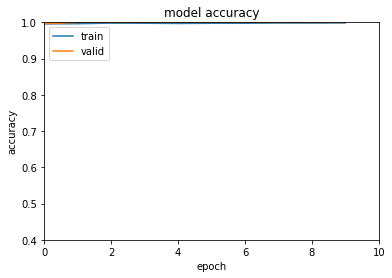

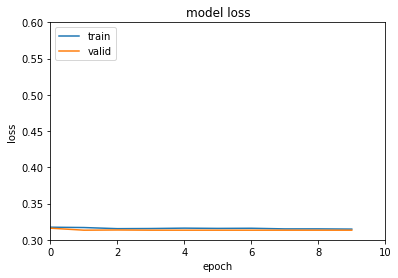

<Figure size 432x288 with 0 Axes>

In [79]:
#plot loss_acc
plot_acc_loss(h)

             WithMask  WithoutMask
WithMask          483            0
WithoutMask         2          507


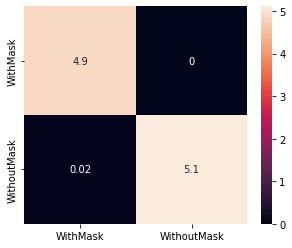

In [80]:
#plot confusion_matrix
df_cm,df_cm_p=confusion_matrix_(dataloaders_test,model)
plt.figure(figsize = (5,4))
sn.heatmap(df_cm_p, annot=True)
plt.savefig('output_CM_model_3.png')
print(df_cm)

In [81]:
torch.save(model,"model_mobilenet.pth")